### Importing Data Set

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)

data = pd.read_excel('default of credit card clients.xls', header=1, index_col=0)

col_names = ['Balance', 'Sex', 'Education', 'Marriage', 'Age',
            'Paid_Sep', 'Paid_Aug', 'Paid_Jul', 'Paid_Jun', 'Paid_May', 'Paid_Apr',
            'Bill_Sep', 'Bill_Aug', 'Bill_Jul', 'Bill_Jun', 'Bill_May', 'Bill_Apr',
            'PayAmt_Sep', 'PayAmt_Aug', 'PayAmt_Jul', 'PayAmt_Jun', 'PayAmt_May', 'PayAmt_Apr',
            'Default']

data.columns = col_names
data = data.astype(str).astype(int)

data.head()

,Balance,Sex,Education,Marriage,Age,Paid_Sep,Paid_Aug,Paid_Jul,Paid_Jun,Paid_May,Paid_Apr,Bill_Sep,Bill_Aug,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,PayAmt_Sep,PayAmt_Aug,PayAmt_Jul,PayAmt_Jun,PayAmt_May,PayAmt_Apr,Default
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Splitting and Scaling Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Label response and predictors
response =['Default']
predictors = [x for x in list(data.columns) if x not in response]

# Step 2: Split data set
y = data[response].copy()
X = data[predictors].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Prepare for scaling
#scaler = StandardScaler().fit(X_train)

# Step 4: Scale the data
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

Note that scaling has been temporarily commented out as the baseline model actually doesn't perform better when using l1 penalty, as we are specifying below)

However, for l2 penalty, scaling leads to the results we get from l1 penalty without scaling. This makes sense, as l2 (ridge) works "better when predictors are of similar magnitude" (QBUS3820), which is not the case here.

Further, **not scaling the data is necessary** for the tweaks that are undertaken below for dealing with the class imbalance.

### Baseline Model

In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='l1')
logit.fit(X_train, np.ravel(y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [4]:
# Score against test set
accuracy = logit.score(X_test, y_test)
print('Accuracy:', accuracy.round(3))

Accuracy: 0.81


In [5]:
# AUC calculation
from sklearn.metrics import roc_auc_score
y_score = logit.fit(X_train, np.ravel(y_train)).decision_function(X_test)

roc_auc = roc_auc_score(y_test, y_score)
print('AUC:', roc_auc.round(3))

AUC: 0.727


In [6]:
# ALTERNATIVE AUC calculation
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc.round(3))

AUC: 0.727


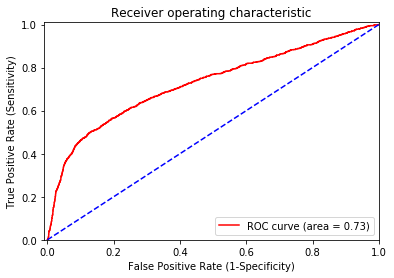

In [7]:
# ROC curve
import matplotlib.pyplot as plt

plt.figure()

plt.plot(fpr, tpr, color='red',
         label='ROC curve (area = {})'.format(roc_auc.round(2)))

plt.plot([0, 1], [0, 1], color='blue', linestyle='--')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])

plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

Recall that we want to maximise the AUC

### Confusion matrix

In [8]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = logit.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cnf_matrix)

Confusion matrix:
 [[4549  138]
 [1002  311]]


In [9]:
import itertools

# Based off http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Truth')
    plt.xlabel('Predicted')
    plt.tight_layout()

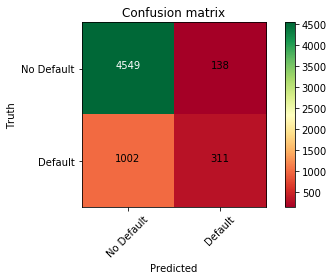

In [10]:
class_names = ['No Default','Default']

plot_confusion_matrix(cnf_matrix, classes=class_names, cmap=plt.cm.RdYlGn,
                      title='Confusion matrix')
plt.show()

Note the order from top to bottom, left to right: TP: 4549 | FN: 138 | FP: 1003 | TN: 310





In [11]:
# Some metrics
total = sum(sum(cnf_matrix))

accuracy = (cnf_matrix[0,0]+cnf_matrix[1,1])/total
sensitivity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
precision = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,1])
specificity = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])

print('Accuracy:', accuracy.round(3))
print('Sensitivity (Recall):', sensitivity.round(3))
print('Precision:', precision.round(3))
print('Specificity:', specificity.round(3))

Accuracy: 0.81
Sensitivity (Recall): 0.971
Precision: 0.936
Specificity: 0.237


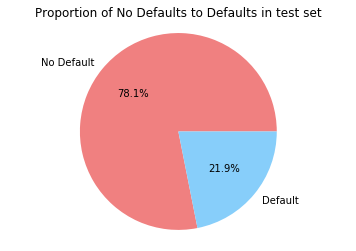

In [13]:
test_class_ratio = y_test['Default'].value_counts()

labels = 'No Default', 'Default'
sizes = [test_class_ratio[0], test_class_ratio[1]]
colors = ['lightcoral', 'lightskyblue']
 
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%.1f%%')
 
plt.axis('equal')
plt.title('Proportion of No Defaults to Defaults in test set')

plt.show()

Basically, we aren't doing much better than guessing... 0.81 to 0.78 (with scaling), without we essentially perform at the theoretical minimum majority class rate (unless we use l1 penalty, then we get the same as scaling basically)

### Dealing with imbalanced classes

In [14]:
train = X_train.join(y_train)
train_majority = train[train['Default']==0]
train_minority = train[train['Default']==1]

Rejoining the split X and y from test_train_split earlier, and then splitting up based on classes

In [15]:
n_majority = train_majority['Default'].count()
n_minority = train_minority['Default'].count()

print('No Defaults:', n_majority)
print('Defaults:', n_minority)

No Defaults: 18677
Defaults: 5323


Clearly, at least in the train set that we split, there are significnatly fewer Default reponses -- this is a class imbalance problem that we must deal with (either via **upsampling the defaults**, or **downsamping the no defaults**)

**Upsampling**: may lead to overfitting due to replications of the minority class, whereas;

**Downsampling**: may lead to bias due to discarding potentially useful info

A third, alternative method we can use is called SMOTE (synthetic minority over-sampling technique) -- link for more info: http://rikunert.com/SMOTE_explained

In [16]:
from sklearn.utils import resample

# Downsampling majority class
train_majority_down = resample(train_majority, replace=False, n_samples=n_minority, random_state=42)
train_down = pd.concat([train_minority, train_majority_down])
X_down = train_down[predictors].copy()
y_down = train_down[response].copy()

# Upsampling minority class
train_minority_up = resample(train_minority, replace=True, n_samples=n_majority, random_state=42)
train_up = pd.concat([train_majority, train_minority_up])
X_up = train_up[predictors].copy()
y_up = train_up[response].copy()

In the first cell, we are downsampling the majority class (no defaults) by essentially resampling without replacement. This allow us to build a new dataset essentially,  only up to the same number of samples as the minority class (5323)

In the second cell, we are upsampling the minority class (defaults) by resampling with replacement, up to the same number of samples as no defaults (18677)

In [17]:
#conda install -c glemaitre imbalanced-learn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, ratio='auto')
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, np.ravel(y_train))

This method uses the SMOTE algorithm as highlighted above. Note that there are many parameters that I've left as default, for simplicty now - but some things to explore are the k neighbours and SVM.

### Running baseline models with the rebalanced classes

In [18]:
%%time
logit_down = LogisticRegression(penalty='l1')
logit_down.fit(X_down, np.ravel(y_down))

Wall time: 203 ms


In [19]:
%%time
logit_up = LogisticRegression(penalty='l1')
logit_up.fit(X_up, np.ravel(y_up))

Wall time: 885 ms


_Note: this took noticably longer to run, due to the upsizing_

In [20]:
%%time
logit_SMOTE = LogisticRegression(penalty='l1')
logit_SMOTE.fit(X_SMOTE, np.ravel(y_SMOTE))

Wall time: 1.07 s


In [21]:
col = ['Accuracy', 'AUC', 'Sensitivity', 'Specificity']
row = ['Logistic', 'Downsampled Logit', 'Upsampled Logit', 'SMOTE Logit']
models = [logit, logit_down, logit_up, logit_SMOTE]

data = [[X_train, y_train],
        [X_up, y_up],
        [X_down, y_down],
        [X_SMOTE, y_SMOTE]]

results = pd.DataFrame(0.0, columns=col, index=row)

n=0
for i in models:
    y_score = i.fit(data[n][0], np.ravel(data[n][1])).decision_function(X_test) # Calculates the score used for the AUC below
   
    y_pred = i.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    
    results.iloc[n,0] = i.score(X_test, y_test)
    results.iloc[n,1] = roc_auc_score(y_test, y_score)    
    results.iloc[n,2] = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
    results.iloc[n,3] = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
    n+=1
    
results

,Accuracy,AUC,Sensitivity,Specificity
Logistic,0.809833,0.727002,0.970557,0.236101
Downsampled Logit,0.690833,0.729419,0.703648,0.645088
Upsampled Logit,0.697667,0.727532,0.713676,0.640518
SMOTE Logit,0.700167,0.728909,0.721144,0.625286


Huge... We see no improvements in the accuracy, however AUC remains constant, and we have dramatically increased Specificity (True Negatives - correct detection of defaults) relative to the trade-off we have against Sensitvity (True Positives).

This may be  useful in a business context, where the cost of NOT DETECTING a default substantially outweighs the profits from several correct detections of non-defaults (i.e. True Positives); that is, we may be able to accept this decrease in Sensitivity, to increase our Specificity.

### OTHER STUFF

Useful links:
1. https://rstudio-pubs-static.s3.amazonaws.com/281390_8a4ea1f1d23043479814ec4a38dbbfd9.html
2. https://www.kaggle.com/lucabasa/credit-card-default-a-very-pedagogical-notebook
3. ~~https://www.kaggle.com/snaveen13/extensive-eda-and-5-classification-algorithm~~
4. https://sevenpillarsinstitute.org/case-studies/taiwans-credit-card-crisis/ (info on Taiwan Credit Crisis)
5. https://en.wikipedia.org/wiki/Sensitivity_and_specificity
6. ~~https://statinfer.com/204-4-2-calculating-sensitivity-and-specificity-in-python/~~
7. https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
8. http://rikunert.com/SMOTE_explained

**To Do:**
* Hypothesis Test
* Confidence Intervals
* Build a loss matrox

LOSS MATRIX:

Truth/Pred | no default | default

no default | profit | loss from potential repayment

default | loss from default | 0

BASELINE MODEL is just going to be treating the problem as business as usual, so that we can compare how much money we save the business from our model

So BASELINE MODEL should just be something like a 50/50 (less naive, but ignorant nonetheless)